In [1]:
import pandas as pd
import os
import dill
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score,
    balanced_accuracy_score)
import scam_job_detector.ML_logic.preprocessor as pre
print("Imported from:", pre.__file__)
print("Functions available:", dir(pre))
from scam_job_detector.ML_logic.preprocessor import train_preprocessor, test_preprocessor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
import shap
from wordcloud import WordCloud

%load_ext autoreload
%autoreload 2

Imported from: /Users/gillestondeur/code/syeda-tabassum-rahaman/scam-job-detector/scam_job_detector/ML_logic/preprocessor.py
Functions available: ['ColumnTransformer', 'FunctionTransformer', 'OneHotEncoder', 'OrdinalEncoder', 'Pipeline', 'SimpleImputer', 'TfidfVectorizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'binary_columns', 'categorical_columns', 'dill', 'make_column_transformer', 'make_pipeline', 'np', 'os', 'pd', 'preprocessing_pipeline', 'test_preprocessor', 'text_columns', 'train_preprocessor', 'train_test_split']


In [2]:
    # -----------------------------
    # Load cleaned dataset
    # -----------------------------

clean_data_path =  "../raw_data/data_cleaned.csv"

df = pd.read_csv(clean_data_path)
print("✅ Clean data loaded")


✅ Clean data loaded


In [3]:
model_path = "../models/final_model.dill"
with open(model_path, "rb") as f:
    model = dill.load(f)
    print("✅ Model loaded")

✅ Model loaded


In [4]:
# -----------------------------
# Train-test split
# -----------------------------
X = df.drop(columns=["fraudulent"],errors="ignore")
y = df["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("✅ Data split into train and test sets")


✅ Data split into train and test sets


## Assess Feature importance through random permutations

In [6]:
# -----------------------------
# Preprocess once
# -----------------------------
X_train_pp, preprocessor_no_text = train_preprocessor(X_train,text=False)
X_test_pp = test_preprocessor(X_test)

# Convert sparse to dense
X_test_dense = pd.DataFrame(X_test_pp.toarray())  # temporarily ignore column names
X_test_dense.columns = [f"f{i}" for i in range(X_test_dense.shape[1])]

Preprocessor saved at /Users/gillestondeur/code/syeda-tabassum-rahaman/scam-job-detector/models/preprocessor.dill


In [7]:
log_pipe = make_pipeline(
    preprocessor_no_text,
    LogisticRegression(max_iter=1000, random_state=42)
)
log_pipe.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [8]:
#Permutation importance function


def logistic_regression_permutation_importance(model_path, X_test_dense, y_test, n_repeats=2):
    """
    Runs permutation importance on a trained logistic regression model.

    model_path: path to your saved logreg model (model_logreg.dill)
    X_test_pp: preprocessed test data
    y_test: true labels of the test data
    """

    # Load trained Logistic Regression model
    with open(model_path, "rb") as f:
        model = dill.load(f)

    # Compute permutation importances
    result = permutation_importance(
        log_pipe,
        X_test_dense,
        y_test,
        n_repeats=n_repeats,
        scoring="average_precision",
        n_jobs=-1,
        random_state=42
    )

    # Convert to readable results
    importance_df = pd.DataFrame({
        "feature": X_test_dense.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False)

    return importance_df

In [9]:
# Run permutation importance
importance_df = logistic_regression_permutation_importance(model_path, X_test, y_test, n_repeats=2)
print(importance_df.head(50))

            feature  importance_mean  importance_std
0  has_company_logo         0.202646        0.001617
2          industry         0.200575        0.005103
5           country         0.108113        0.007982
1   employment_type         0.030290        0.014225
3          function         0.000000        0.000000
4   job_description         0.000000        0.000000


In [10]:
#Make new preprocessor with text only
X_train_text_only_pp, preprocessor_text_only = train_preprocessor(X_train, text_only=True)
X_test_text_only_pp = test_preprocessor(X_test)


Preprocessor saved at /Users/gillestondeur/code/syeda-tabassum-rahaman/scam-job-detector/models/preprocessor.dill


In [11]:
#fit model with text only preprocessor
xgb_text_only = make_pipeline(
    preprocessor_text_only,
    XGBClassifier(objective="binary:logistic",
                  eval_metric="logloss",
                  n_jobs=-1,
                  random_state=42,
                  learning_rate=0.1,
                  max_depth=11,
                  n_estimators=275,
                  verbose=1
        )
)
results = xgb_text_only.fit(X_train, y_train)

/Users/gillestondeur/.pyenv/versions/3.10.6/envs/scam_job_detector/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [10:44:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [12]:
#make xgb teext only predictions on test set and evaluate
y_pred = xgb_text_only.predict(X_test)
y_proba = xgb_text_only.predict_proba(X_test)[:, 1]

print("Accuracy_text_only:", accuracy_score(y_test, y_pred))
print("Precision_text_only:", precision_score(y_test, y_pred))
print("Recall_text_only:", recall_score(y_test, y_pred))
print("F1 Score_text_only:", f1_score(y_test, y_pred))
print("Balanced Accuracy_text_only:", balanced_accuracy_score(y_test, y_pred))

# Metrics that require probabilities
print("Average Precision (AP)_text_only:", average_precision_score(y_test, y_proba))
print("ROC-AUC_text_only:", roc_auc_score(y_test, y_proba))

Accuracy_text_only: 0.9840604026845637
Precision_text_only: 0.9833333333333333
Recall_text_only: 0.6820809248554913
F1 Score_text_only: 0.8054607508532423
Balanced Accuracy_text_only: 0.8407466040674754
Average Precision (AP)_text_only: 0.9292685681193695
ROC-AUC_text_only: 0.9897727099006487


In [45]:
X_train_pp, preprocessor = train_preprocessor(X_train,text=True)
X_test_pp = test_preprocessor(X_test)
X_train_pp.shape

Preprocessor saved at /Users/gillestondeur/code/syeda-tabassum-rahaman/scam-job-detector/models/preprocessor.dill


(14304, 381374)

In [14]:
#fit XGB with all features
xgb_all_features = make_pipeline(
    preprocessor,
    XGBClassifier(objective="binary:logistic",
                  eval_metric="logloss",
                  n_jobs=-1,
                  random_state=42,
                  learning_rate=0.1,
                  max_depth=11,
                  n_estimators=275
    ))
results_all_features = xgb_all_features.fit(X_train, y_train)
results_all_features

,steps,"[('columntransformer', ...), ('xgbclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [38]:
X_train.head()

,has_company_logo,employment_type,industry,function,job_description,country
7530,1,Full-time,Financial Services,Customer Service,contact center representatives tidewater finan...,US
129,1,Full-time,Telecommunications,Customer Service,customer service associate novitex enterprise ...,US
4640,1,Full-time,Information Technology and Services,NaN,automate test analyst silverstripe cms amp fra...,NZ
402,1,Full-time,Building Materials,Sales,inside sales professionalomaha abc supply co i...,US
13218,1,Full-time,Internet,Marketing,content marketingseo manager meundies lifestyl...,US


In [15]:
#make xgb all features predictions on test set and evaluate
y_pred_all_features = xgb_all_features.predict(X_test)
y_proba_all_features = xgb_all_features.predict_proba(X_test)[:, 1]

print(f"Accuracy_all_features: {accuracy_score(y_test, y_pred_all_features)}, Accuracy_text_only: {accuracy_score(y_test, y_pred)}")
print(f"Precision_all_features: {precision_score(y_test, y_pred_all_features)}, Precision_text_only: {precision_score(y_test, y_pred)}")
print(f"Recall_all_features: {recall_score(y_test, y_pred_all_features)}, Recall_text_only: {recall_score(y_test, y_pred)}")
print(f"F1 Score_all_features: {f1_score(y_test, y_pred_all_features)}, F1 Score_text_only: {f1_score(y_test, y_pred)}")
print(f"Balanced Accuracy_all_features: {balanced_accuracy_score(y_test, y_pred_all_features)}, Balanced Accuracy_text_only: {balanced_accuracy_score(y_test, y_pred)}")

# Metrics that require probabilities
print(f"Average Precision (AP)_all_features: {average_precision_score(y_test, y_proba_all_features)}, Average Precision (AP)_text_only: {average_precision_score(y_test, y_proba)}")
print(f"ROC-AUC_all_features: {roc_auc_score(y_test, y_proba_all_features)}, ROC-AUC_text_only: {roc_auc_score(y_test, y_proba)}")

Accuracy_all_features: 0.9868568232662193, Accuracy_text_only: 0.9840604026845637
Precision_all_features: 0.9772727272727273, Precision_text_only: 0.9833333333333333
Recall_all_features: 0.7456647398843931, Recall_text_only: 0.6820809248554913
F1 Score_all_features: 0.8459016393442623, F1 Score_text_only: 0.8054607508532423
Balanced Accuracy_all_features: 0.8723915824017909, Balanced Accuracy_text_only: 0.8407466040674754
Average Precision (AP)_all_features: 0.9470360412372351, Average Precision (AP)_text_only: 0.9292685681193695
ROC-AUC_all_features: 0.9947547131993362, ROC-AUC_text_only: 0.9897727099006487


## TFIDF Grid search 

In [ ]:
# Define text transformer for text only preprocessor

# def combine_text(X):
    # return X[text_columns].fillna("").agg(" ".join, axis=1)

# make pipeline text transformer

# text_transformer = make_pipeline(
#     FunctionTransformer(combine_text, validate=False),
#     TfidfVectorizer(max_features=5000)
# )
# make pipeling with text transformer and xgb

pipe_TFIDF = Pipeline([
    ('text', preprocessor_text_only),
    ('clf', XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
        learning_rate=0.1,
        max_depth=11,
        n_estimators=275
    ))
])
# param grid for grid search on TFIDF
param_grid = {
'text__pipeline__tfidfvectorizer__max_features': [3000, 5000, 8000, None],
'text__pipeline__tfidfvectorizer__ngram_range': [(1,1), (1,2)],
'text__pipeline__tfidfvectorizer__min_df': [1, 2, 3],
'text__pipeline__tfidfvectorizer__max_df': [0.8, 0.9, 1.0],
'text__pipeline__tfidfvectorizer__sublinear_tf': [True, False]
}
# Run grid search
search_TFIDF = GridSearchCV(
    pipe_TFIDF,
    param_grid=param_grid,
    scoring='average_precision',
    cv=3,
    n_jobs=-1,
    verbose=2
)
best_TDFIDF= search_TFIDF.fit(X_train, y_train)

print("Best score:", best_TFIDF.best_score_)
print("Best params:", best_TFIDF.best_params_)
print("Best estimator:", best_TFIDF.best_estimator_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


ValueError: Invalid parameter 'tfidfvectorizer' for estimator ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function preprocessing_pipeline.<locals>.combine_text at 0x104e8e5f0>)),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(max_features=5000))]),
                                 ['title', 'company_profile', 'description',
                                  'requirements', 'benefits'])]). Valid parameters are: ['force_int_remainder_cols', 'n_jobs', 'remainder', 'sparse_threshold', 'transformer_weights', 'transformers', 'verbose', 'verbose_feature_names_out'].

## Shapley values

In [5]:
model_path = "../models/final_model.dill"
preprocessor_path = "../models/preprocessor.dill"

In [6]:
# load the model and preprocessor
with open(model_path, "rb") as f:
    model = dill.load(f)

with open(preprocessor_path, "rb") as f:
    preprocessor = dill.load(f)

print("Model:", model)
print("Preprocessor loaded:", type(preprocessor))


Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=275, n_jobs=-1,
              num_parallel_tree=None, ...)
Preprocessor loaded: <class 'sklearn.compose._column_transformer.ColumnTransformer'>


In [7]:
# -----------------------------
# 1️⃣ Extract fitted components
# -----------------------------

def model_predict(X):
    return model.predict_proba(X)[:, 1]

# -----------------------------
# 2️⃣ Prepare background and input
# -----------------------------
#Sample background for SHAP
#

In [8]:
background_df = (
    df
    .drop(columns=["fraudulent"], errors="ignore")
    .sample(20, random_state=42)
)

X_background = preprocessor.transform(background_df)


In [9]:
explainer = shap.KernelExplainer(
    model_predict,
    X_background
)

In [10]:
sample = df.sample(1)
X_transformed = preprocessor.transform(
    sample.drop(columns=["fraudulent"], errors="ignore")
)
y= sample["fraudulent"]

In [11]:
shap_values = explainer.shap_values(X_transformed)

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/gillestondeur/.pyenv/versions/3.10.6/envs/scam_job_detector/lib/python3.10/site-packages/xgboost/data.py:1281: UserWarning: Unknown data type: <class 'scipy.sparse._lil.lil_matrix'>, trying to convert it to csr_matrix
  warnings.warn(
/Users/gillestondeur/.pyenv/versions/3.10.6/envs/scam_job_detector/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: divide by zero encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/gillestondeur/.pyenv/versions/3.10.6/envs/scam_job_detector/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: overflow encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/gillestondeur/.pyenv/versions/3.10.6/envs/scam_job_detector/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: invalid value encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)


In [12]:
feature_names = preprocessor.get_feature_names_out()
len(feature_names), shap_values.shape[1]

shap_df = pd.DataFrame({
    "feature": feature_names,
    "shap_value": shap_values[0]
})

shap_df["abs_value"] = shap_df["shap_value"].abs()

top_features = shap_df.sort_values(
    "abs_value", ascending=False
).head(20)
top_features[["feature", "shap_value", "abs_value"]]

,feature,shap_value,abs_value
225,pipeline-2__has_company_logo_0,-0.012141,0.012141
354689,columntransformer__tfidfvectorizer__urgent,-0.005387,0.005387
376455,columntransformer__tfidfvectorizer__years,-0.005257,0.005257
224572,columntransformer__tfidfvectorizer__offshore,-0.004791,0.004791
177705,columntransformer__tfidfvectorizer__join,-0.003453,0.003453
45033,columntransformer__tfidfvectorizer__care,-0.003444,0.003444
371081,columntransformer__tfidfvectorizer__work,-0.003078,0.003078
86732,columntransformer__tfidfvectorizer__design,-0.002837,0.002837
188232,columntransformer__tfidfvectorizer__lift,-0.002754,0.002754
323952,columntransformer__tfidfvectorizer__strong,-0.002454,0.002454


In [13]:
text_mask = shap_df.feature.str.contains("tfidfvectorizer__")
binary_mask = shap_df.feature.str.contains("has_company_logo")
country_mask = shap_df.feature.str.contains("country_")

text_df = shap_df[text_mask]
text_df = text_df[text_df.abs_value>0]
binary_df = shap_df[binary_mask]
country_df = shap_df[country_mask]


In [14]:
text_df

,feature,shap_value,abs_value
45033,columntransformer__tfidfvectorizer__care,-0.003444,0.003444
86732,columntransformer__tfidfvectorizer__design,-0.002837,0.002837
177705,columntransformer__tfidfvectorizer__join,-0.003453,0.003453
188232,columntransformer__tfidfvectorizer__lift,-0.002754,0.002754
224572,columntransformer__tfidfvectorizer__offshore,-0.004791,0.004791
323952,columntransformer__tfidfvectorizer__strong,-0.002454,0.002454
354689,columntransformer__tfidfvectorizer__urgent,-0.005387,0.005387
371081,columntransformer__tfidfvectorizer__work,-0.003078,0.003078
376455,columntransformer__tfidfvectorizer__years,-0.005257,0.005257


In [15]:
#Create function to extract word from feature name

def extract_word(feature):
    return feature.split("tfidfvectorizer__")[-1]

In [16]:
# Apply function to text_df
text_df["word"] = text_df["feature"].apply(extract_word)
text_df

,feature,shap_value,abs_value,word
45033,columntransformer__tfidfvectorizer__care,-0.003444,0.003444,care
86732,columntransformer__tfidfvectorizer__design,-0.002837,0.002837,design
177705,columntransformer__tfidfvectorizer__join,-0.003453,0.003453,join
188232,columntransformer__tfidfvectorizer__lift,-0.002754,0.002754,lift
224572,columntransformer__tfidfvectorizer__offshore,-0.004791,0.004791,offshore
323952,columntransformer__tfidfvectorizer__strong,-0.002454,0.002454,strong
354689,columntransformer__tfidfvectorizer__urgent,-0.005387,0.005387,urgent
371081,columntransformer__tfidfvectorizer__work,-0.003078,0.003078,work
376455,columntransformer__tfidfvectorizer__years,-0.005257,0.005257,years


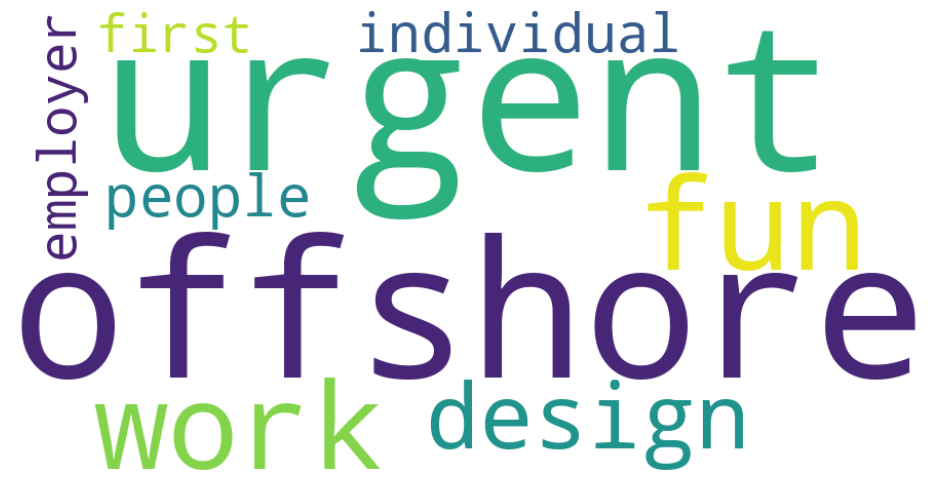

16155    0
Name: fraudulent, dtype: int64


In [121]:
word_freq = dict(zip(text_df.word, text_df.abs_value))

wc = WordCloud(
    width=900,
    height=450,
    background_color="white"
).generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
print(y)

In [106]:
# Create explanation function for company logo feature
def explain_has_logo(row):
    if "_0" in row.feature:
        if row.shap_value > 0:
            return "Missing company logo increases the likelihood that this job posting is fake."
        else:
            return "Despite the missing company logo, other signals suggest this posting may be legitimate."
    if "_1" in row.feature:
        return "The presence of a company logo increases the credibility of the job posting."

# Apply explanation function to binary_df
binary_df["explanation"] = binary_df.apply(explain_has_logo, axis=1)

/var/folders/00/_l7nrzwn7zn69mqvxq9pmzr00000gn/T/ipykernel_37552/1398480855.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_df["explanation"] = binary_df.apply(explain_has_logo, axis=1)


In [122]:
#Create function to extract country from feature name
def extract_country(feature):
    return feature.split("country_")[-1]

country_df["country"] = country_df.feature.apply(extract_country)

#Apply to country_df
def explain_country(row):
    country = row.country
    if row.shap_value > 0:
        return f"Job postings originating from {country} are statistically more likely to be fraudulent."
    else:
        return f"Job postings originating from {country} are generally less associated with fraud in the training data."

country_df["explanation"] = country_df.apply(explain_country, axis=1)

/var/folders/00/_l7nrzwn7zn69mqvxq9pmzr00000gn/T/ipykernel_37552/2352249985.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df["country"] = country_df.feature.apply(extract_country)
/var/folders/00/_l7nrzwn7zn69mqvxq9pmzr00000gn/T/ipykernel_37552/2352249985.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df["explanation"] = country_df.apply(explain_country, axis=1)


In [125]:
explanation = {
    "top_words": text_df.sort_values("abs_value", ascending=False)
                        .head(10)["word"]
                        .tolist(),
    "signals": (
        pd.concat([binary_df, country_df])
        .dropna(subset=["explanation"])
        .sort_values("abs_value", ascending=False)
        .head(5)["explanation"]
        .tolist()
    )
}
explanation

{'top_words': ['urgent',
  'offshore',
  'fun',
  'work',
  'design',
  'people',
  'individual',
  'employer',
  'first'],
 'signals': ['Job postings originating from AE are generally less associated with fraud in the training data.',
  'Job postings originating from LK are generally less associated with fraud in the training data.',
  'Job postings originating from PT are generally less associated with fraud in the training data.',
  'Job postings originating from PL are generally less associated with fraud in the training data.',
  'Job postings originating from PK are generally less associated with fraud in the training data.']}

In [88]:
for _, row in top_features.iterrows():
    direction = "FAKE ↑" if row["shap_value"] > 0 else "REAL ↓"
    print(f"{row['feature']}: {direction} ({row['shap_value']:.4f})")

pipeline-2__has_company_logo_0: REAL ↓ (-0.0082)
columntransformer__tfidfvectorizer__offshore: REAL ↓ (-0.0056)
columntransformer__tfidfvectorizer__work: REAL ↓ (-0.0050)
columntransformer__tfidfvectorizer__urgent: REAL ↓ (-0.0048)
columntransformer__tfidfvectorizer__understand: REAL ↓ (-0.0043)
columntransformer__tfidfvectorizer__fun: REAL ↓ (-0.0043)
pipeline-1__country_US: REAL ↓ (-0.0042)
pipeline-1__country_GB: REAL ↓ (-0.0036)
columntransformer__tfidfvectorizer__requirements: REAL ↓ (-0.0033)
columntransformer__tfidfvectorizer__love: REAL ↓ (-0.0033)
columntransformer__tfidfvectorizer__preferredstrong verbal: REAL ↓ (0.0000)
columntransformer__tfidfvectorizer__preferredstrong work: REAL ↓ (0.0000)
columntransformer__tfidfvectorizer__preferredstrong presentation: REAL ↓ (0.0000)
columntransformer__tfidfvectorizer__preferredthis: REAL ↓ (0.0000)
columntransformer__tfidfvectorizer__preferredthe compensationbest: REAL ↓ (0.0000)
columntransformer__tfidfvectorizer__preferredthe: REAL 